In [1]:
import veloxchem as vlx
import py3Dmol as p3d
from veloxchem.veloxchemlib import bohr_in_angstroms

from matplotlib import pyplot as plt
import numpy as np

In [2]:
basis_set_label = '6-31G'

In [3]:
# Prepare molecules and basis sets

# Read optimized geometry from file
h2o_xyz = open("../../data/ir_raman/opt_h2o.xyz", "r").read()
nh3_xyz = open("../../data/ir_raman/opt_nh3.xyz", "r").read()
ch4_xyz = open("../../data/ir_raman/opt_ch4.xyz", "r").read()

h2o = vlx.Molecule.read_xyz_string(h2o_xyz)
h2o_basis = vlx.MolecularBasis.read(h2o, basis_set_label, ostream=None)

nh3 = vlx.Molecule.read_xyz_string(nh3_xyz)
nh3_basis = vlx.MolecularBasis.read(nh3, basis_set_label, ostream=None)

ch4 = vlx.Molecule.read_xyz_string(ch4_xyz)
ch4_basis = vlx.MolecularBasis.read(ch4, basis_set_label, ostream=None)

In [4]:
print("\n       (a) H2O                   (b) NH3                  (c) CH4")
viewer = p3d.view(viewergrid=(1,3),width=600,height=250, linked=True)
viewer.addModel(h2o_xyz, 'xyz', viewer=(0,0))
viewer.addModel(nh3_xyz, 'xyz', viewer=(0,1))
viewer.addModel(ch4_xyz, 'xyz', viewer=(0,2))
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.show()


       (a) H2O                   (b) NH3                  (c) CH4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
# Settings:
method_settings = {}

# Numerical Hessian
vib_settings = {'do_raman': 'yes', 'print_depolarization_ratio':'yes'}

# We first need to run SCF calculations:
h2o_scf_drv = vlx.ScfRestrictedDriver()
h2o_scf_drv.ostream.mute()
h2o_results = h2o_scf_drv.compute(h2o, h2o_basis)

nh3_scf_drv = vlx.ScfRestrictedDriver()
nh3_scf_drv.ostream.mute()
nh3_results = nh3_scf_drv.compute(nh3, nh3_basis)

ch4_scf_drv = vlx.ScfRestrictedDriver()
ch4_scf_drv.ostream.mute()
ch4_results = ch4_scf_drv.compute(ch4, ch4_basis)

In [6]:
# Create a Hessian driver object, update settings, and compute 
h2o_vibanalysis_drv = vlx.VibrationalAnalysis(h2o_scf_drv)
h2o_vibanalysis_drv.update_settings(method_settings, vib_settings)

nh3_vibanalysis_drv = vlx.VibrationalAnalysis(nh3_scf_drv)
nh3_vibanalysis_drv.update_settings(method_settings, vib_settings)

ch4_vibanalysis_drv = vlx.VibrationalAnalysis(ch4_scf_drv)
ch4_vibanalysis_drv.update_settings(method_settings, vib_settings)

In [7]:
# Calculate hessians from scratch
h2o_results = h2o_vibanalysis_drv.compute(h2o, h2o_basis, h2o_scf_drv)
nh3_results = nh3_vibanalysis_drv.compute(nh3, nh3_basis, nh3_scf_drv)
ch4_results = ch4_vibanalysis_drv.compute(ch4, ch4_basis, ch4_scf_drv)

In [8]:
def add_broadening(list_ex_energy, list_osci_strength, line_profile='Lorentzian', line_param=10, step=10):
        x_min = np.amin(list_ex_energy) - 50
        x_max = np.amax(list_ex_energy) + 50
        x = np.arange(x_min, x_max, step)
        y = np.zeros((len(x)))

        # go through the frames and calculate the spectrum for each frame
        for xp in range(len(x)):
            for e, f in zip(list_ex_energy, list_osci_strength):
                if line_profile == 'Gaussian':
                    y[xp] += f * np.exp(-(
                        (e - x[xp]) / line_param)**2)
                elif line_profile == 'Lorentzian':
                    y[xp] += 0.5 * line_param * f / (np.pi * (
                        (x[xp] - e)**2 + 0.25 * line_param**2))
        return x, y

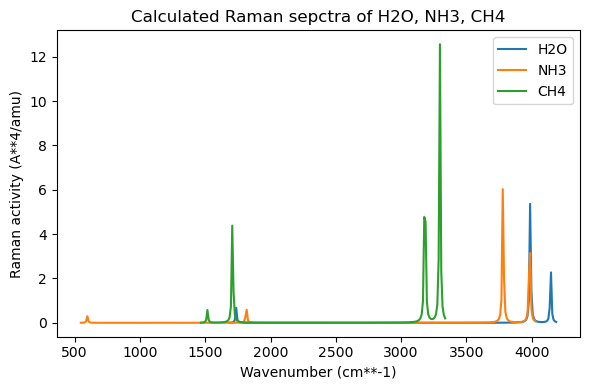

In [9]:
# plot the Raman spectra
plt.figure(figsize=(6,4))

freq = 0

h2o_x,h2o_y = h2o_vibanalysis_drv.vib_frequencies, h2o_vibanalysis_drv.raman_activities[freq]
nh3_x,nh3_y = nh3_vibanalysis_drv.vib_frequencies, nh3_vibanalysis_drv.raman_activities[freq]
ch4_x,ch4_y = ch4_vibanalysis_drv.vib_frequencies, ch4_vibanalysis_drv.raman_activities[freq]

h2o_xl, h2o_yl = add_broadening(h2o_x, h2o_y, line_profile='Lorentzian', line_param=10, step=10)
nh3_xl, nh3_yl = add_broadening(nh3_x, nh3_y, line_profile='Lorentzian', line_param=10, step=10)
ch4_xl, ch4_yl = add_broadening(ch4_x, ch4_y, line_profile='Lorentzian', line_param=10, step=10)

plt.plot(h2o_xl, h2o_yl, label='H2O')
plt.plot(nh3_xl, nh3_yl, label='NH3')
plt.plot(ch4_xl, ch4_yl, label='CH4')

plt.xlabel('Wavenumber (cm**-1)')
plt.ylabel('Raman activity (A**4/amu)')
plt.title("Calculated Raman sepctra of H2O, NH3, CH4")
plt.legend()
plt.tight_layout(); plt.show()

In [10]:
# To animate the normal mode we will need both the geometry and the displacements 
def get_normal_mode(molecule, normal_mode):
    elements = molecule.get_labels()
    coords = molecule.get_coordinates_in_angstrom()
    natm = molecule.number_of_atoms()
    vib_xyz = "%d\n\n" % natm
    nm = normal_mode.reshape(natm, 3)
    
    for i in range(natm):
        # add coordinates:
        vib_xyz += elements[i] + " %15.7f %15.7f %15.7f " % (coords[i,0], coords[i,1], coords[i,2])
        # add displacements:
        vib_xyz += "%15.7f %15.7f %15.7f\n" % (nm[i,0], nm[i,1], nm[i,2])
    return vib_xyz

In [11]:
h2o_h1 = get_normal_mode(h2o, h2o_vibanalysis_drv.normal_modes[-2])
h2o_h2 = get_normal_mode(h2o, h2o_vibanalysis_drv.normal_modes[-1])

nh3_h1 = get_normal_mode(nh3, nh3_vibanalysis_drv.normal_modes[-3])
nh3_h2 = get_normal_mode(nh3, nh3_vibanalysis_drv.normal_modes[-2])
nh3_h3 = get_normal_mode(nh3, nh3_vibanalysis_drv.normal_modes[-1])

ch4_h1 = get_normal_mode(ch4, ch4_vibanalysis_drv.normal_modes[-4])
ch4_h2 = get_normal_mode(ch4, ch4_vibanalysis_drv.normal_modes[-3])
ch4_h3 = get_normal_mode(ch4, ch4_vibanalysis_drv.normal_modes[-2])
ch4_h4 = get_normal_mode(ch4, ch4_vibanalysis_drv.normal_modes[-1])

In [12]:
print("These are the two H stretching modes of H2O.")
view = p3d.view(viewergrid=(1,2), width=300, height=200, linked=True)
view.addModel(h2o_h1, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,0))
view.addModel(h2o_h2, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,1))

view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick":{},"sphere": {"scale":0.25}})
view.animate({'loop': 'backAndForth'})
view.rotate(120, "x")
view.zoomTo()
view.show()

These are the two H stretching modes of H2O.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
print("These are the three H stretching modes of NH3.")
view = p3d.view(viewergrid=(1,3), width=600, height=200, linked=True)
view.addModel(nh3_h1, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,0))
view.addModel(nh3_h2, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,1))
view.addModel(nh3_h3, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,2))

view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick":{},"sphere": {"scale":0.25}})
view.animate({'loop': 'backAndForth'})
view.rotate(90, "x")
view.zoomTo()
view.show()

These are the three H stretching modes of NH3.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
print("These are the four H stretching modes of CH4.")
view = p3d.view(viewergrid=(1,4), width=600, height=200, linked=True)
view.addModel(ch4_h1, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,0))
view.addModel(ch4_h2, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,1))
view.addModel(ch4_h3, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,2))
view.addModel(ch4_h4, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}}, viewer=(0,3))

view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick":{},"sphere": {"scale":0.25}})
view.animate({'loop': 'backAndForth'})
view.zoomTo()
view.show()

These are the four H stretching modes of CH4.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.